In [1]:
import os
import tqdm

import pandas as pd
import geopandas as gpd
import numpy as np
from shapely import wkt
from shapely.geometry import Point, Polygon
from shapely.ops import nearest_points
from rtree import index

import matplotlib.pyplot as plt
import seaborn as sns

import osmnx as ox
import requests
import re
from PIL import Image
from io import BytesIO
import copy
import json

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

import pano

save_folder = "/media/data_16T/maoransu/projects/building_material"

### Download data

### Filter images

**get successfully downloaded gsvs**

In [2]:
# get successfully downloaed gsvs
# load downloaded gsv infos
fileInfo = pd.read_pickle(os.path.join(save_folder,"data/gsv_fileInfo.p")).reset_index(drop=True)
fileInfo['path'] = [os.path.join(p,n) for p,n in zip(fileInfo.folder, fileInfo.name)]
fileInfo['id_angle'] = fileInfo['name'].apply(lambda x: x.split('.jpg')[0])

# get gsv request info
gsvInfo = pd.read_pickle(os.path.join(save_folder,"data/glasgow_for_gsv_origin.p")).reset_index(drop=True)

In [3]:
# join gsvinfo and gsv request info
gsv_downloaded = gsvInfo[['id', 'id_angle', 'year', 'Property_UPRN', 'attrs']].merge(fileInfo[['path', 'id_angle']], on='id_angle')

In [7]:
gsv_downloaded.year.min(), gsv_downloaded.year.max()

(2008.0, 2021.0)

**join ratings to downloaded gsv**

In [4]:
# join rating to data
for_panoid = pd.read_pickle(os.path.join(save_folder, 'data/glasgow_for_panoid.p'))
data_all = gsv_downloaded.merge(for_panoid[['id', 'Current energy efficiency rating band']], on='id') 
data_all = data_all.rename(columns={'Current energy efficiency rating band':'rating'})

In [5]:
print(data_all.shape)
display(data_all.head(3))

(903086, 7)


id                      id_angle    year  Property_UPRN  \
0  building_1000917116  hyDZREv2MX3CrS9OTSXA9A_38_16  2012.0     1000917116   
1  building_1000917116  l7hfTn3ErDhsDM4zOIaO9w_41_18  2009.0     1000917116   
2  building_1000917116  VoMsowTanoKwVp_4fbfmFg_40_16  2019.0     1000917116   

                                               attrs  \
0  [0.03406510219530658, 0.09328358208955224, 0.1...   
1  [0.03406510219530658, 0.09328358208955224, 0.1...   
2  [0.03406510219530658, 0.09328358208955224, 0.1...   

                                                path rating  
0  /media/data_16T/maoransu/projects/building_mat...      C  
1  /media/data_16T/maoransu/projects/building_mat...      C  
2  /media/data_16T/maoransu/projects/building_mat...      C

**filter images with segmentation result**

In [6]:
# load segmentation result
resultDF = pd.read_pickle(os.path.join(save_folder,'data/glasgow_segmentation_result.p'))

# filter images with building as largest area
result_building = resultDF[resultDF.idxmax(axis=1) == 'building']

# filter images with building larger than 40% area
result_building = result_building[result_building.building / result_building.sum(axis=1) > 0.4]

# select images
data_all = data_all[data_all.id_angle.isin(result_building.index)].reset_index(drop=True)

In [7]:
print(data_all.shape)
display(data_all.head(3))

(741767, 7)


id                      id_angle    year  Property_UPRN  \
0  building_1000917116  hyDZREv2MX3CrS9OTSXA9A_38_16  2012.0     1000917116   
1  building_1000917116  l7hfTn3ErDhsDM4zOIaO9w_41_18  2009.0     1000917116   
2  building_1000917116  VoMsowTanoKwVp_4fbfmFg_40_16  2019.0     1000917116   

                                               attrs  \
0  [0.03406510219530658, 0.09328358208955224, 0.1...   
1  [0.03406510219530658, 0.09328358208955224, 0.1...   
2  [0.03406510219530658, 0.09328358208955224, 0.1...   

                                                path rating  
0  /media/data_16T/maoransu/projects/building_mat...      C  
1  /media/data_16T/maoransu/projects/building_mat...      C  
2  /media/data_16T/maoransu/projects/building_mat...      C

In [8]:
data_all.to_pickle(os.path.join(save_folder,'data/glasgow_dataset_final.p'), protocol=3)

### Inspect dataset samples and split dataset

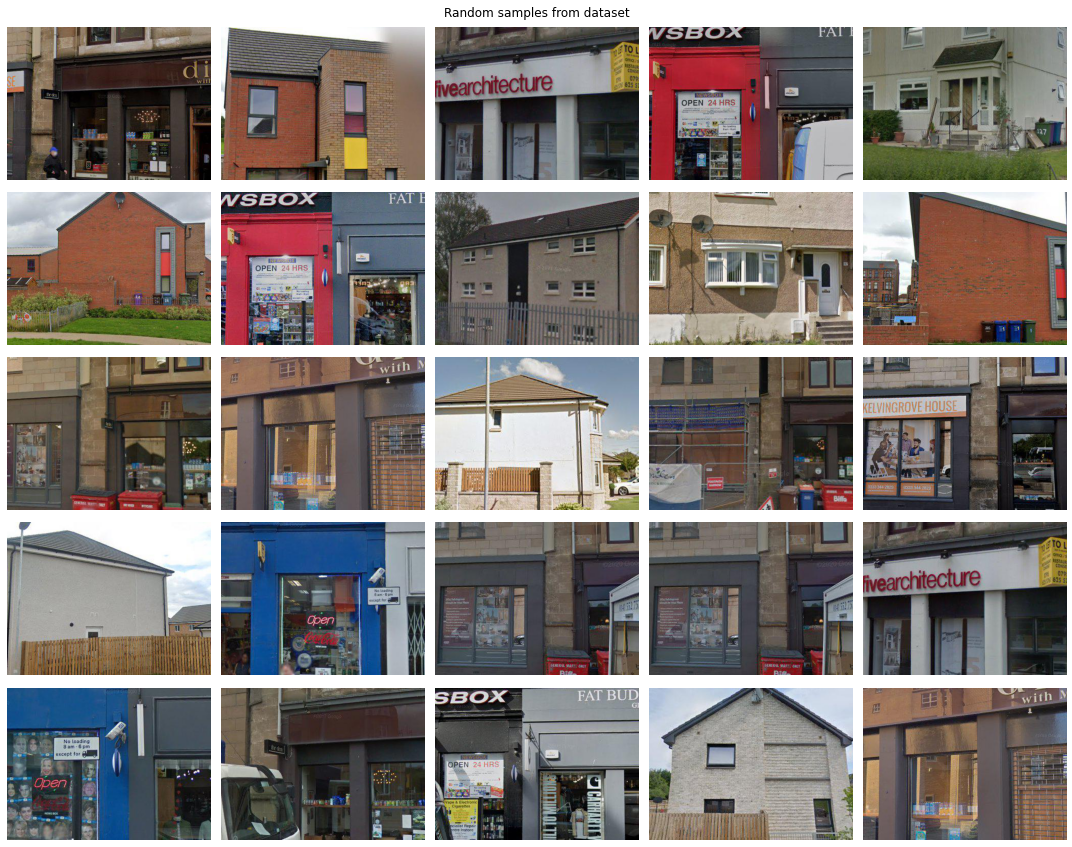

In [8]:
# display(Image.open(np.random.choice(data_all.path)))
paths = data_all[data_all['rating'] == 'A'].path.sample(25)

fig, ax = plt.subplots(5,5, figsize=(15,12))

for i in range(5):
    for j in range(5):
        idx = i*5+j
        ax[i,j].imshow(Image.open(paths.iloc[i*5+j]))
        ax[i,j].axis('off')

fig.suptitle('Random samples from dataset')
fig.tight_layout()
plt.show()

### Split train & test set

**check if duplicated**

In [2]:
# load data
data_all = pd.read_pickle(os.path.join(save_folder,'data/glasgow_dataset_final.p'))

In [3]:
# make attrs column hashable, convert to string
data_all['attrs_str'] = data_all['attrs'].apply(lambda x:' '.join([str(i) for i in x]))

In [4]:
# drop duplicate records
data_all = data_all.drop_duplicates(subset=['path', 'attrs_str'])
print(data_all.shape)

(707183, 8)


**make sure images should have two years of gap**

In [24]:
def checkYearGap_2(tempDF):
    years = sorted(tempDF['year'].unique())
    consecutiveIndex = []
    length = len(years)
    for i in range(length-1):
        if abs(years[i] - years[i+1]) < 3:
            if i not in consecutiveIndex:
                consecutiveIndex.append(i+1)
            if i < length - 2:
                if abs(years[i+2] - years[i]) < 3:
                    if i not in consecutiveIndex:
                        consecutiveIndex.append(i+2)
    if len(years) == 0:
        return None
    else:
        return [(j, years[p]) for p in consecutiveIndex]

gapped = []

for j in tqdm.tqdm(data_all['id'].unique()):
    temp = data_all[data_all['id']==j]
    result = checkYearGap_2(temp)
    if result is not None:
        gapped.extend(result)

100%|██████████| 132728/132728 [1:03:57<00:00, 34.59it/s]


In [25]:
# save result
with open(os.path.join(save_folder, 'data/id_year_to_delete_gap_2.json'), 'w') as f:
    json.dump(gapped, f)

In [26]:
# load gapped information
with open(os.path.join(save_folder, 'data/id_year_to_delete_gap_2.json'), 'r') as f:
    gapped_read = json.load(f)

In [28]:
# drop consecutive year images for same building
data_all['id_year'] = [i+'_'+str(y) for i,y in zip(data_all['id'], data_all['year'])]
id_yearToDelete = [g[0]+'_'+str(g[1]) for g in gapped]

data_all_gapped = data_all[~data_all['id_year'].isin(id_yearToDelete)].drop(columns=['id_year']).reset_index(drop=True)

split gapped data and mix

In [9]:
# split train and validation
train_property = np.random.choice(data_all['id'].unique(), int(len(data_all['id'].unique())*0.85), replace=False)
train_property_train = np.random.choice(train_property, int(len(train_property)*0.8), replace=False)
train_property_val = train_property[~np.isin(train_property, train_property_train)]
# train_property[~train_property_train.isin(train_property_train)]

test_property = data_all['id'][~data_all['id'].isin(train_property)].unique()

In [17]:
# split dataset
trainDF = data_all[data_all['id'].isin(train_property_train)].reset_index(drop=True)
valDF = data_all[data_all['id'].isin(train_property_val)].reset_index(drop=True)
testDF = data_all[data_all['id'].isin(test_property)].reset_index(drop=True)

In [23]:
trainDF['split'] = 'train'
valDF['split'] = 'val'
testDF['split'] = 'val'

In [24]:
trainDF.to_pickle(os.path.join(save_folder, 'data/training/train_raw_v2.p'), protocol=3)
valDF.to_pickle(os.path.join(save_folder, 'data/training/val_raw_v2.p'), protocol=3)
testDF.to_pickle(os.path.join(save_folder, 'data/training/test_raw_v2.p'), protocol=3)

### building training set

In [25]:
# load data
trainDF = pd.read_pickle(os.path.join(save_folder, 'data/training/train_raw_v2.p'))
valDF = pd.read_pickle(os.path.join(save_folder, 'data/training/val_raw_v2.p'))
testDF = pd.read_pickle(os.path.join(save_folder, 'data/training/test_raw_v2.p'))

In [33]:
trainDF = pd.concat([trainDF, valDF]).reset_index(drop=True)

In [34]:
# convert rating to label
label_map = {"A":0, "B":1, "C":2, "D":3, "E":4, "F":5, "G":6}
trainDF['label'] = trainDF['rating'].apply(lambda x:label_map[x])
testDF['label'] = testDF['rating'].apply(lambda x:label_map[x])

In [35]:
# testDF['split'] = 'val'
testDF['task'] = 0
testDF = testDF[['id','path','label','task','split', 'rating', 'attrs', 'Property_UPRN', 'year']].sample(frac=1).reset_index(drop=True)
testDF.to_pickle(os.path.join(save_folder, 'data/training/fusion_test_mix_v1_gap2.p'), protocol=3)

In [38]:
trainDF.to_pickle(os.path.join(save_folder, 'data/training/fusion_train_mix_v1_gap2.p'), protocol=3)

**training comands**

UK buildings

python /home/maoransu/projects/building_material/main_multibranch.py /media/data_16T/maoransu/projects/building_material/data/training/fusion_train_mix_v0_gap2_UK.p -c=7 -inDIM=38 -outDIM=256 -s /media/data_16T/maoransu/projects/building_material/output/model_fusion_mix_v0_UKbuilding -b 100 --gpu='0,1' -p --epochs 40 --lr-rate=0.005 --lr-deStep=20

#### Check training and test dataset

In [22]:
trainDF = pd.read_pickle("/media/data_16T/maoransu/projects/building_material/data/training/fusion_train_v2.p")
testDF = pd.read_pickle("/media/data_16T/maoransu/projects/building_material/data/training/fusion_test_v2.p")

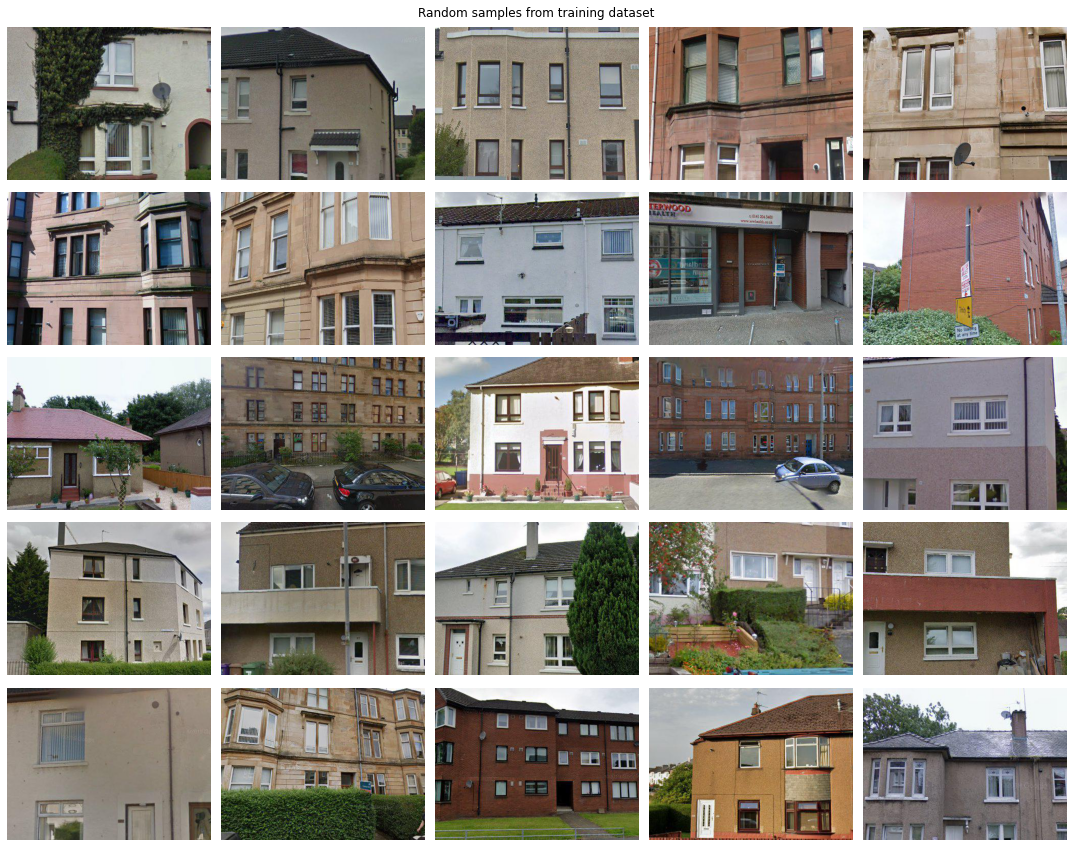

In [7]:
# get image samples from training data
paths = trainDF[trainDF['split'] == 'train'].path.sample(25)

fig, ax = plt.subplots(5,5, figsize=(15,12))

for i in range(5):
    for j in range(5):
        idx = i*5+j
        ax[i,j].imshow(Image.open(paths.iloc[i*5+j]))
        ax[i,j].axis('off')

fig.suptitle('Random samples from training dataset')
fig.tight_layout()
plt.show()

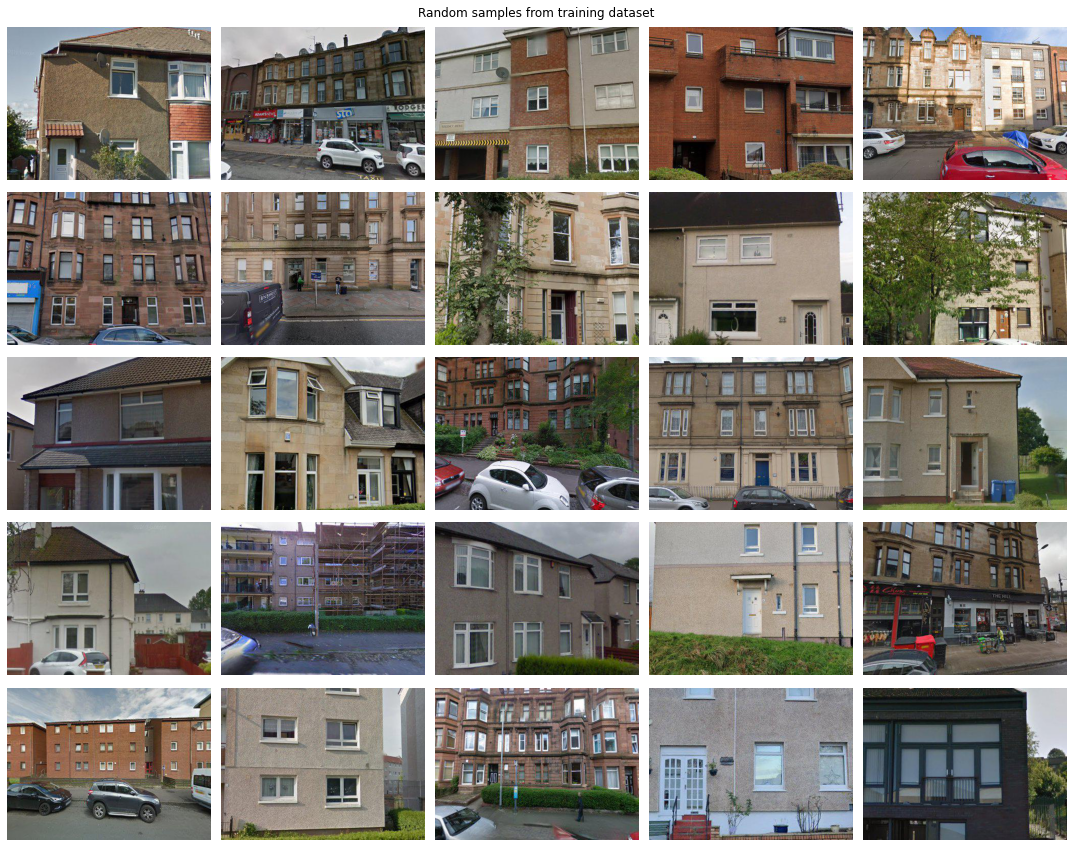

In [8]:
# get image samples from validation data
paths = trainDF[trainDF['split'] == 'val'].path.sample(25)

fig, ax = plt.subplots(5,5, figsize=(15,12))

for i in range(5):
    for j in range(5):
        idx = i*5+j
        ax[i,j].imshow(Image.open(paths.iloc[i*5+j]))
        ax[i,j].axis('off')

fig.suptitle('Random samples from training dataset')
fig.tight_layout()
plt.show()

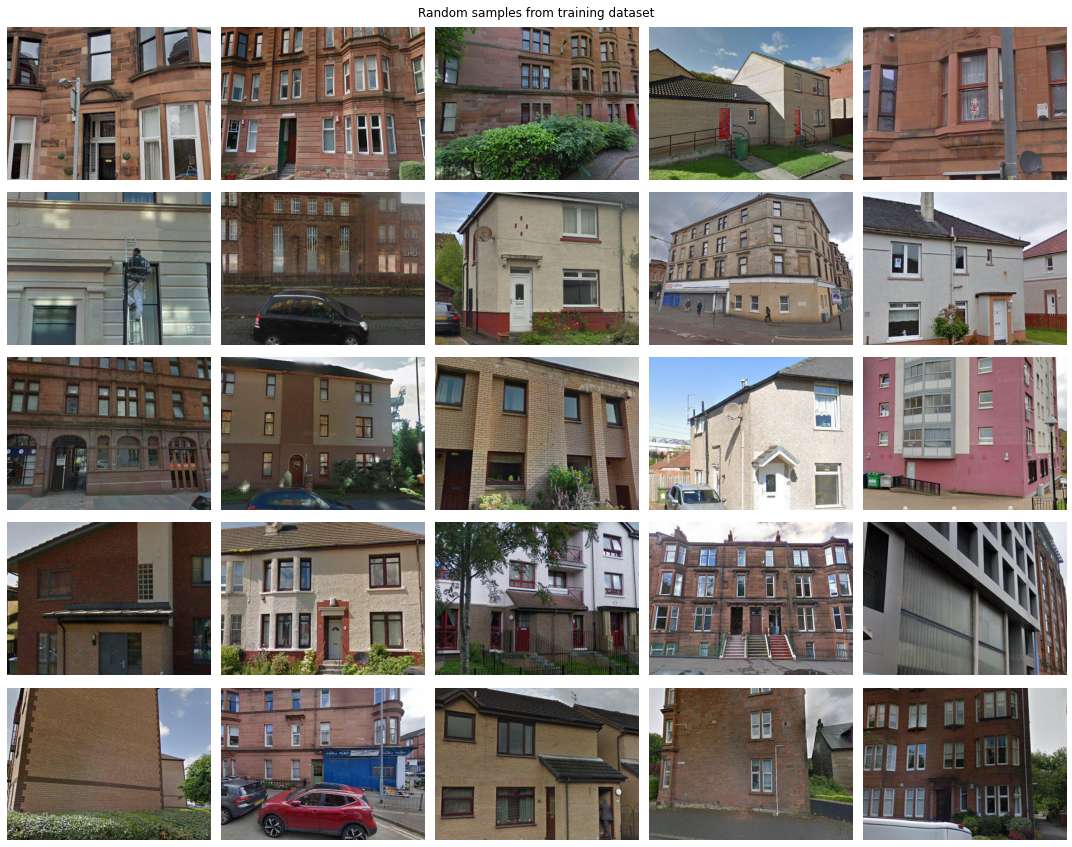

In [10]:
# get image samples from test data
paths = testDF.path.sample(25)

fig, ax = plt.subplots(5,5, figsize=(15,12))

for i in range(5):
    for j in range(5):
        idx = i*5+j
        ax[i,j].imshow(Image.open(paths.iloc[i*5+j]))
        ax[i,j].axis('off')

fig.suptitle('Random samples from training dataset')
fig.tight_layout()
plt.show()

## check training process

In [1]:
import pandas as pd
import seaborn as sns

Best Validation ACC: 86.57564544677734


<AxesSubplot:xlabel='epoch', ylabel='top1'>

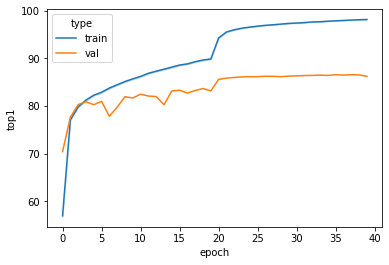

In [5]:
training = pd.read_pickle("/media/data_16T/maoransu/projects/building_material/output/model_fusion_mix_v0_UKbuilding/2021-12-07_log.p")
print('Best Validation ACC:', training[training['type']=='val']['top1'].max())
sns.lineplot(data=training, x='epoch', y='top1', hue='type')


## evaluation

python /home/maoransu/projects/building_material/main_multibranch.py /media/data_16T/maoransu/projects/building_material/data/training/fusion_test_mix_v0_gap2_UK.p -c=7 -inDIM=38 -outDIM=256 -s /media/data_16T/maoransu/projects/building_material/output/model_fusion_mix_v0_UKbuilding -b 100 --gpu='0,1' -p -e --resume /media/data_16T/maoransu/projects/building_material/output/model_fusion_mix_v0_UKbuilding/model_best.pth.tar

In [3]:
folder = '/media/data_16T/maoransu/projects/building_material/output/model_fusion_mix_v1'

evlDF = pd.read_pickle(os.path.join(folder,'2021-12-11_evaluate.p'))
evlDF['result'] = evlDF.label == evlDF.predict
# evlDF[evlDF.split == 'val'].groupby(['label','result']).count()

Normalized confusion matrix


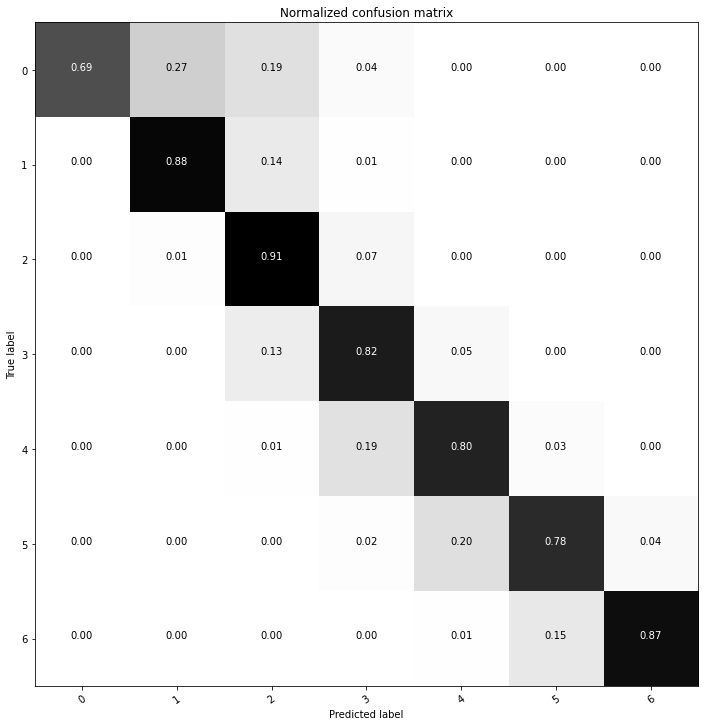

In [5]:
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
%matplotlib inline
# dd[(dd.city=='seoul')&(dd.predict=='seoul')].sort_values(by='predict_prob',ascending=False)

# only training set of HK
DF2 = evlDF

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)

#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=35)
    plt.yticks(tick_marks, classes)
#     plt.colorbar()
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig(os.path.join(folder, 'confusionMatrix.jpg'),bbox_inches='tight', dpi=600)
class_names = [range(7)] 

y_test = evlDF[evlDF.split == 'val'].label.to_list()
y_pred = evlDF[evlDF.split == 'val'].predict.to_list()

cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# cnf_matrix2 = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

plot_confusion_matrix(cnf_matrix, classes=class_names[0], normalize=True,
                      title='Normalized confusion matrix')
plt.show()
